## Prerequisites

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

In [2]:
def display_data(fake_data, train_data):
    fake_data = pd.DataFrame(fake_data)
    fake_data.head()

    train_data = pd.DataFrame(train_data)
    train_data.head()

    fake_data["label"] = 1
    train_data["label"] = 0
    
    data = pd.concat([fake_data, train_data])
    data.head()

    sns.pairplot(data, hue='label')
    
def norm(x, mu, theta):
    return (x - mu)/theta

def denorm(x, mu, theta):
    return x * theta + mu

## Observation of data

Let's see how our data look like

In [3]:
df = pd.read_csv('data/train.csv', header=None)
train_data = np.array(df.drop(labels=0, axis=1))
data_dim = train_data.shape[1]

In [4]:
def augmentor(train_data, size):
    X = train_data ** 0.25

    mu = np.mean(X, axis=0)
    cov = np.cov(X.T)
    
    generated = np.random.multivariate_normal(mu, cov, size) ** 4
    
    return generated

In [5]:
def generate_data(train_data, Z):
    X = train_data ** 0.25

    mu = np.mean(X, axis=0)
    
    
    cov = np.cov(X.T)
    
    B = np.linalg.cholesky(cov)
    
    
    generated = (mu + np.dot(Z, B.T)) ** 4
    
    return generated

In [6]:
size = train_data.shape[0]

mu_Z = np.zeros(train_data.shape[1])
cov_Z = np.eye(train_data.shape[1])
Z = np.random.multivariate_normal(mu_Z, cov_Z, size)
Z

array([[ 0.57934406,  0.18641967,  0.40066727, -0.38503086],
       [-0.61693454,  0.86411292, -0.04081712, -0.31297994],
       [-0.99721434,  0.94359768,  0.02783072,  0.58105866],
       ...,
       [-1.08069979,  0.79065661,  1.36617727, -0.85979717],
       [ 0.66688634,  0.9387309 , -0.62193117,  1.69104415],
       [-0.64780395,  0.55787649, -0.82847527, -0.76950636]])

In [7]:
generated = generate_data(train_data, Z)
generated.shape

(746, 4)

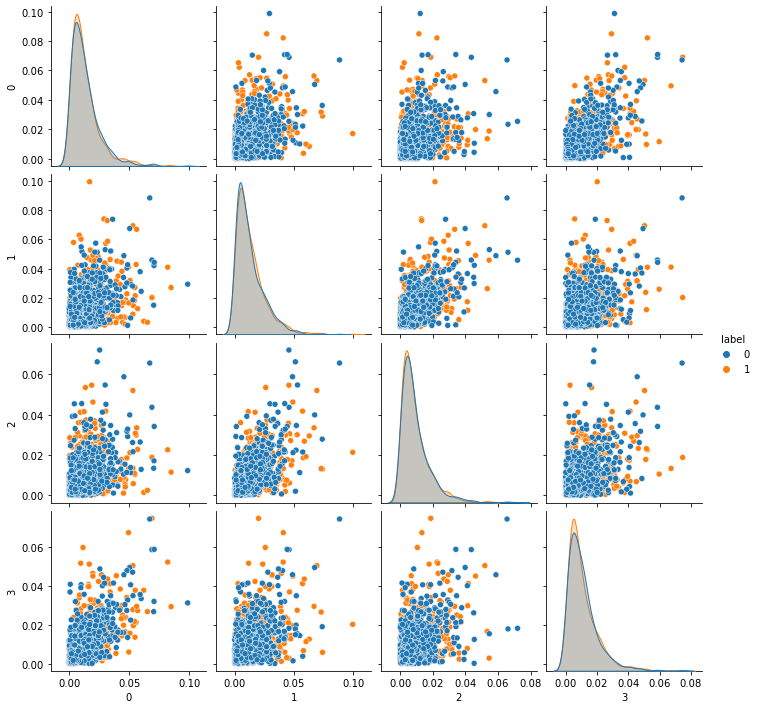

In [8]:
display_data(generated, train_data)

### Definition of GAN models

In [9]:
import torch
import torch.nn as nn

if torch.cuda.is_available():
    print('You use GPU !')
    device = torch.device('cuda')
else:
    print('You use CPU !')
    device = torch.device('cpu')

You use GPU !


In [10]:
# Generative model
def make_generator(noise_dim):
    return nn.Sequential(
        nn.Conv1d(in_channels=noise_dim, out_channels=128, kernel_size=1),
        nn.LeakyReLU(),
        nn.BatchNorm1d(128),
        
        nn.Conv1d(in_channels=128, out_channels=64, kernel_size=1),
        nn.LeakyReLU(),
        nn.BatchNorm1d(64),
        
        nn.Flatten(),
        
        nn.Linear(in_features=64, out_features=data_dim),
        nn.ReLU(),
    )


# Discriminative model
def make_discriminator():
    return nn.Sequential(
        nn.ConvTranspose1d(in_channels=data_dim, out_channels=64, kernel_size=1),
        nn.BatchNorm1d(64),
        nn.LeakyReLU(),
        
        nn.ConvTranspose1d(in_channels=64, out_channels=16, kernel_size=1),
        nn.BatchNorm1d(16),
        nn.LeakyReLU(),
        
        nn.Flatten(),
        
        nn.Linear(in_features=16, out_features=2)
    )

## Training

Split dataset into training data and evaluation data

In [11]:
n_augmented_data = 50000
augmented = augmentor(train_data, n_augmented_data)
augmented_data = np.concatenate([augmented, train_data])

In [12]:
X = torch.tensor(augmented_data , dtype=torch.float).to(device) ** 0.25
mu = X.mean(dim=0)
theta = torch.sqrt(((X - mu)**2).mean(dim=0))
X = norm(X, mu, theta)

eval_rate = 0.
eval_index = int(X.shape[0] * (1 - eval_rate))
X_train = X[0: eval_index]
X_eval = X[eval_index:]

batch_size = 64

X_train_loader = torch.utils.data.DataLoader(X_train, batch_size, shuffle=True)
# X_eval_loader = torch.utils.data.DataLoader(X_eval, batch_size, shuffle=True)

We choose Adam Optimizer ($\beta_1 = 0.9$, $\beta_2 = 0.999$)

In [13]:
noise_dim = 8
generator = make_generator(noise_dim=noise_dim).to(device)
discriminator = make_discriminator().to(device)


num_epochs = 100
lr = 0.001
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)

criterion = torch.nn.CrossEntropyLoss()

In [14]:
def reshape(data):
    return data.view(data.shape[0], data.shape[1], 1)

In [15]:
tk = tqdm(range(num_epochs))

for i in tk:
    disc_losses = []
    gen_losses = []
    for true_data in X_train_loader:
        #### DISCRIMINATOR OPTMIZATION ####
        n_data = true_data.shape[0]
        
        discriminator.train() # Unfreeze parameters of the discriminator
        generator.eval() # Freeze parameters of the generator
        
        disc_optimizer.zero_grad()
        
        true_x = true_data.to(device) # true data from the training dataset
        
        noise = torch.randn(n_data, noise_dim).to(device)
        noise = reshape(noise)
        
        fake_x = generator(noise).detach() # fake data from the noise distribution ~ N(0, 1)

        x = torch.cat([true_x, fake_x]) # Gather true and fake data
        x = reshape(x)
        
        
        true_y = torch.ones((n_data,), dtype=torch.long).to(device) # target 1 for true data
        fake_y = torch.zeros((n_data,), dtype=torch.long).to(device) # target 0 for fake data
        
        y = torch.cat([true_y, fake_y]) # Gather true and fake targets
        
        
        
        output = discriminator(x)
        
        disc_loss = criterion(output, y) # Penalize Discriminator for failing to distinguish fake data from true data
        disc_losses.append(disc_loss.item())
        
        disc_loss.backward()
        
        
        disc_optimizer.step() # Optimize Discriminator
        
        
        
        ### GENERATOR OPTIMIZATION ###
        n_data = true_data.shape[0] * 2
    
        discriminator.eval() # Freeze parameters of the discriminator
        generator.train() # Unfreeze parameters of the generator

        gen_optimizer.zero_grad()
        
        
        noise = torch.randn(n_data, noise_dim).to(device)
        noise = reshape(noise)
        fake_x = generator(noise) # fake data from the noise distribution ~ N(0, 1)
        
        true_y = torch.ones((n_data,), dtype=torch.long).to(device) # target 1 for true data
        
        fake_x = reshape(fake_x)
        output = discriminator(fake_x)
        
        gen_loss = criterion(output, true_y) # Penalize Generator for failing to fool the discriminator
        gen_losses.append(gen_loss.item())
        
        gen_loss.backward()
        

        gen_optimizer.step() # Optimize Generator  
    
    
    disc_loss = np.mean(disc_losses)
    gen_loss = np.mean(gen_losses)
    
    tk.set_postfix({"disc_loss": disc_loss, "gen_loss": gen_loss})

100%|██████████| 100/100 [05:51<00:00,  3.52s/it, disc_loss=0.311, gen_loss=1.73]


In [16]:
discriminator.eval()
generator.eval()

Sequential(
  (0): Conv1d(8, 128, kernel_size=(1,), stride=(1,))
  (1): LeakyReLU(negative_slope=0.01)
  (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
  (4): LeakyReLU(negative_slope=0.01)
  (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=64, out_features=4, bias=True)
  (8): ReLU()
)

In [17]:
example = torch.randn(batch_size*4, noise_dim).to(device)
example = reshape(example)

generated = generator(example)
generated = reshape(generated)

discriminator(generated).argmax(dim=1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [18]:
x = reshape(X)
discriminator(x).argmax(dim=1)[:300]

tensor([1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
        1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
        1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
        0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
        1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
        0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

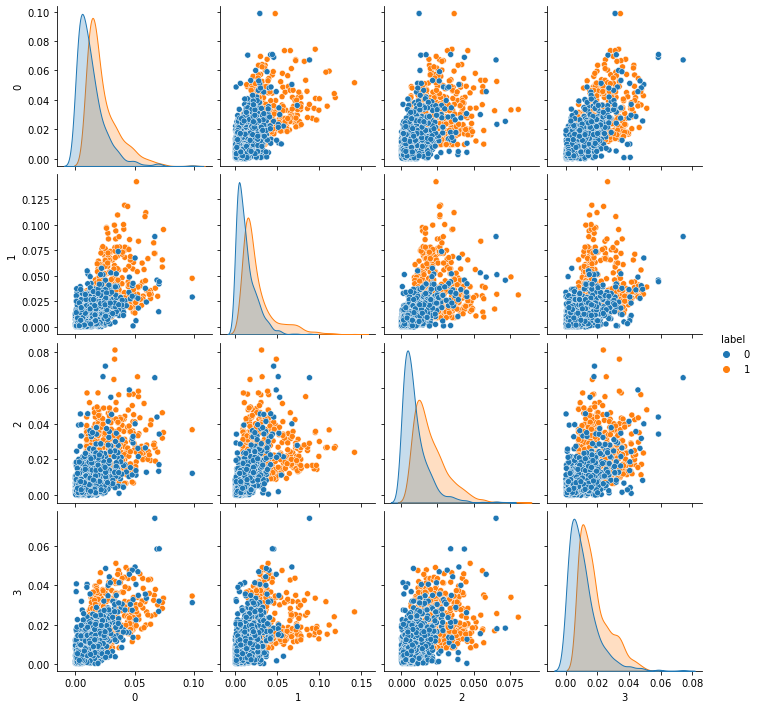

In [19]:
fake_data = generator(reshape(torch.randn(train_data.shape[0], noise_dim).to(device)))
fake_data = denorm(fake_data, mu, theta) ** 4
fake_data = fake_data.detach().cpu().numpy()

display_data(fake_data, train_data)

In [20]:
fake_data[:10]

array([[0.02782549, 0.02235953, 0.04570654, 0.01138924],
       [0.0449908 , 0.03083707, 0.01673941, 0.03845691],
       [0.01840368, 0.01610075, 0.00727675, 0.00814612],
       [0.01287926, 0.00941848, 0.0213713 , 0.01080574],
       [0.01700485, 0.02042412, 0.02514388, 0.01670574],
       [0.02996325, 0.02337907, 0.00663678, 0.01589885],
       [0.03835465, 0.02799277, 0.0204109 , 0.01558578],
       [0.02853394, 0.06870756, 0.02361402, 0.02527749],
       [0.01813455, 0.03476894, 0.00916328, 0.01423032],
       [0.02829368, 0.05364241, 0.01422832, 0.01897831]], dtype=float32)